In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import datetime as dt
from datetime import timedelta

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data.csv']


In [2]:
df = pd.read_csv("../input/data.csv", encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()/df.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

25% of CustomerID values are missing. It might be people who are not registered so they are buying without account. That's what I think at the first glance. But for purpose of this analysis I'm about to drop these rows.

In [5]:
df.dropna(subset=['CustomerID'], inplace=True)

In [6]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
print('Number of rows', df.shape[0])

Number of rows 406829


There are 406829 rows but as you can see 1 row is not equal to 1 transactions. Every row means 1 listing on the invoice.

In [8]:
#types
for c in ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']:
    df[c] = df[c].astype('category')
#dates    
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['DayOfWeek'] = df['DayOfWeek'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df['Hour'] = df['InvoiceDate'].dt.hour

#invoice
df['StockValue'] = df['Quantity']*df['UnitPrice']

In [9]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())
print(df['InvoiceDate'].max() - df['InvoiceDate'].min())

2010-12-01 08:26:00
2011-12-09 12:50:00
373 days 04:24:00


Period of analysis is 1 year with additional couple days.

In [10]:
def column_statistic(column):
    plt.figure(figsize=(20,10))
    sns.boxplot(df[column])
    print(df[column].describe())
    print('-'*10)
    print('Variation coefficient {}'.format(df[column].std()/df[column].mean()))
    print('-'*10)
    print('Minimum values')
    print(df[column].sort_values().head(5))
    print('Maximum values')
    print(df[column].sort_values(ascending=False).head(5))

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64
----------
Variation coefficient 20.61911236435448
----------
Minimum values
540422   -80995
61624    -74215
4287      -9360
160145    -3114
160144    -2000
Name: Quantity, dtype: int64
Maximum values
540421    80995
61619     74215
502122    12540
421632     4800
206121     4300
Name: Quantity, dtype: int64


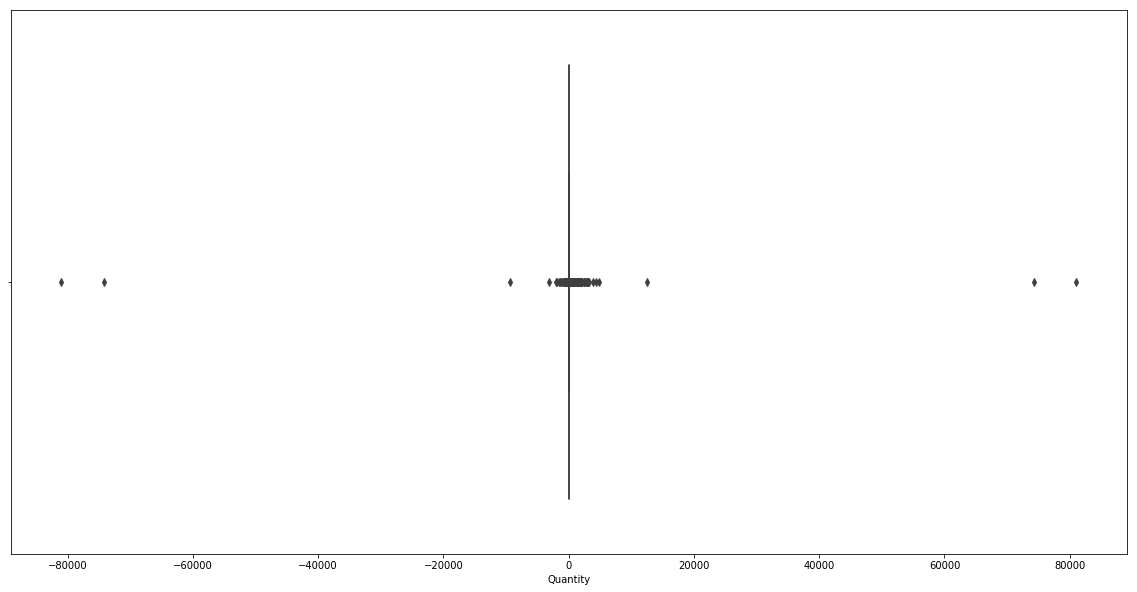

In [11]:
column_statistic('Quantity')

In [12]:
df[df['Quantity'] < 0].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,StockValue
398624,C571251,22625,RED KITCHEN SCALES,-2,2011-10-14 16:57:00,8.50,13814.0,Germany,2011,10,14,Friday,16,-17.00
19124,C537838,22299,PIG KEYRING WITH LIGHT & SOUND,-4,2010-12-08 15:01:00,1.25,13115.0,United Kingdom,2010,12,8,Wednesday,15,-5.00
293376,C562594,22464,HANGING METAL HEART LANTERN,-24,2011-08-07 15:44:00,1.65,12748.0,United Kingdom,2011,8,7,Sunday,15,-39.60
394040,C570867,22199,FRYING PAN RED RETROSPOT,-4,2011-10-12 16:17:00,4.25,12607.0,USA,2011,10,12,Wednesday,16,-17.00
246779,C558727,22605,WOODEN CROQUET GARDEN SET,-1,2011-07-01 14:35:00,10.95,12709.0,Germany,2011,7,1,Friday,14,-10.95


There are invoices which have negative number of quantity of some listings. As you can see those invoices have letter "C" at the beggining of invoice number. I suppose these are credit notes. Let's mark them. 2 listings with highest value of quantity have been turned back.

In [13]:
df['InvoiceType'] = df['InvoiceNo'].apply(lambda x: 'FK' if x[:1] == 'C' else 'FV')

count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64
----------
Variation coefficient 20.03055692478358
----------
Minimum values
187613    0.0
446794    0.0
298054    0.0
436961    0.0
436597    0.0
Name: UnitPrice, dtype: float64
Maximum values
222681    38970.00
173382     8142.75
173277     8142.75
173391     6930.00
268027     4287.63
Name: UnitPrice, dtype: float64


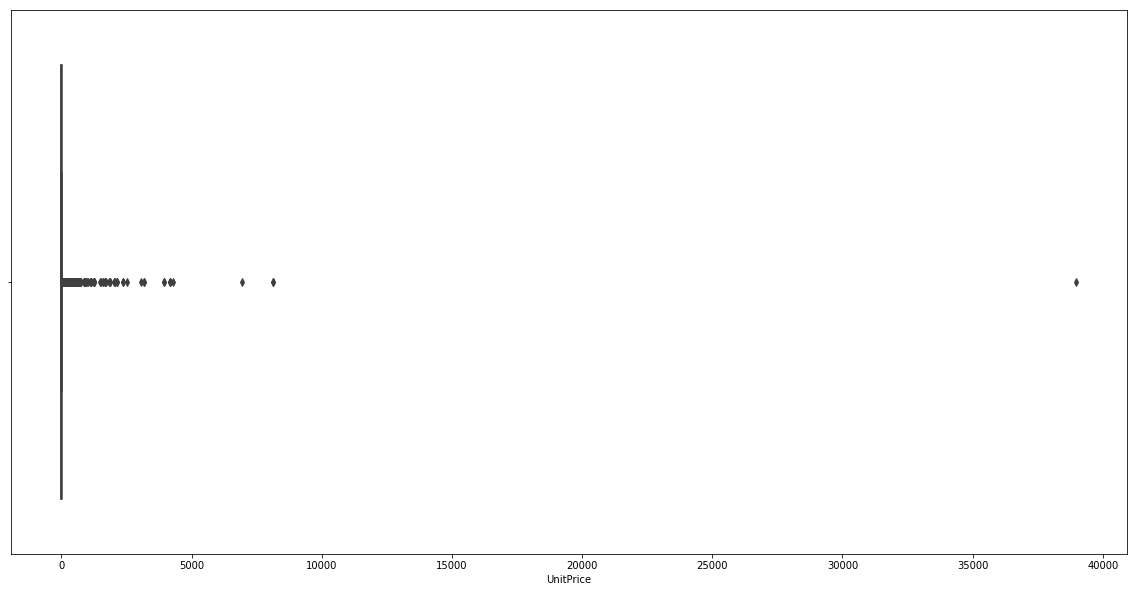

In [14]:
column_statistic('UnitPrice')

In [15]:
df[df['UnitPrice'] == 0].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,StockValue,InvoiceType
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,2011,1,6,Thursday,16,0.0,FV
446125,574879,22625,RED KITCHEN SCALES,2,2011-11-07 13:22:00,0.0,13014.0,United Kingdom,2011,11,7,Monday,13,0.0,FV
285657,561916,M,Manual,1,2011-08-01 11:44:00,0.0,15581.0,United Kingdom,2011,8,1,Monday,11,0.0,FV
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.0,16133.0,United Kingdom,2011,9,25,Sunday,12,0.0,FV
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646.0,Netherlands,2011,8,26,Friday,14,0.0,FV


Some of the listings on invoices have 0 unit prices. It must be some kind of discounts or promotions.

# Sales over time

In [16]:
group_type = df.groupby('InvoiceType')['InvoiceNo'].nunique()
print('We have got {0} invoices and {1} correcting invoices'.format(group_type[1],
                                                                    group_type[0]))
print('Its about {0} invoices and {1} correcting invoices per day'.format(group_type[1]/373,
                                                                        group_type[0]/373))

We have got 18536 invoices and 3654 correcting invoices
Its about 49.69436997319035 invoices and 9.796246648793566 correcting invoices per day


Total number of invoices is 22190, which 83,5% are sales invoices and the rest are credit notes.

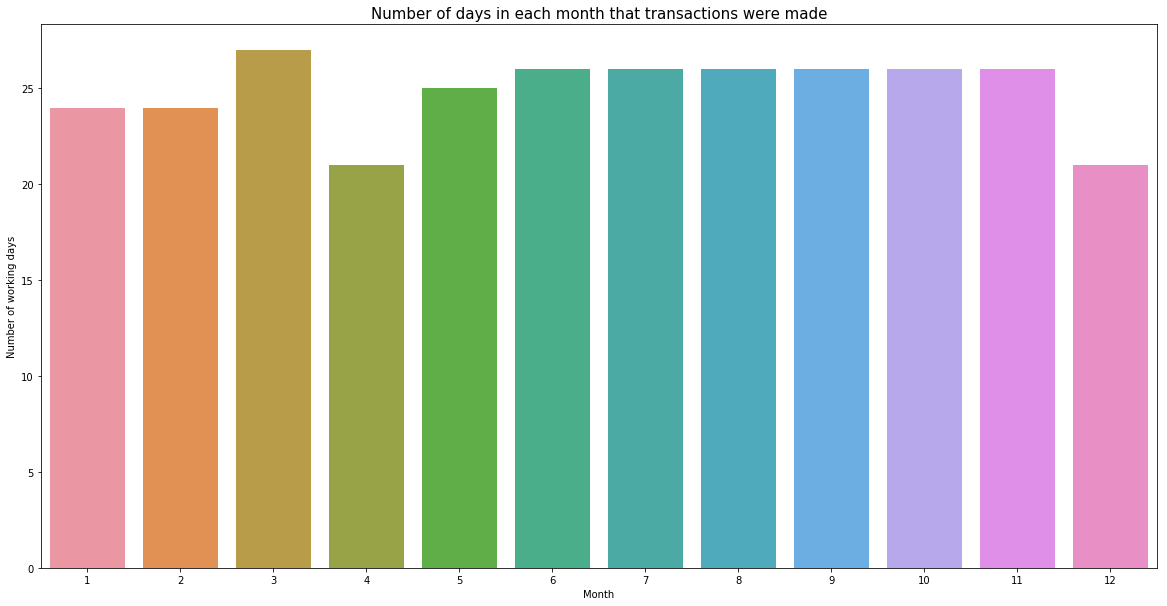

In [17]:
date_group = df.groupby('Month')['Day'].nunique()
plt.figure(figsize=(20,10))
sns.barplot(date_group.index, date_group.values)
plt.ylabel('Number of working days')
plt.xlabel('Month')
plt.title('Number of days in each month that transactions were made', fontsize=15)
plt.show()

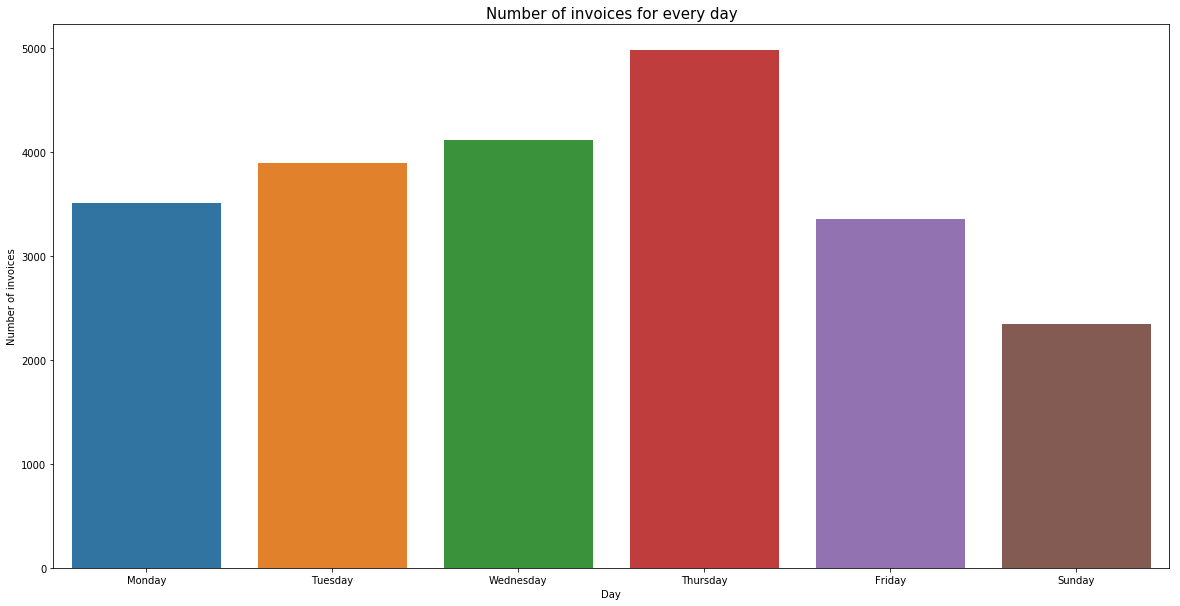

In [18]:
dayweek_group = df.groupby('DayOfWeek')['InvoiceNo'].nunique()
plt.figure(figsize=(20,10))
sns.barplot(dayweek_group.index, dayweek_group.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
plt.ylabel('Number of invoices')
plt.xlabel('Day')
plt.title('Number of invoices for every day', fontsize=15)
plt.show()

The working days are on more or less on the same level through the year. Interesting fact is that there are no transactions on Saturday at all and day with highest number of invoices is Thursday

# Customers

There are 4372 customers who made 22190 transactions


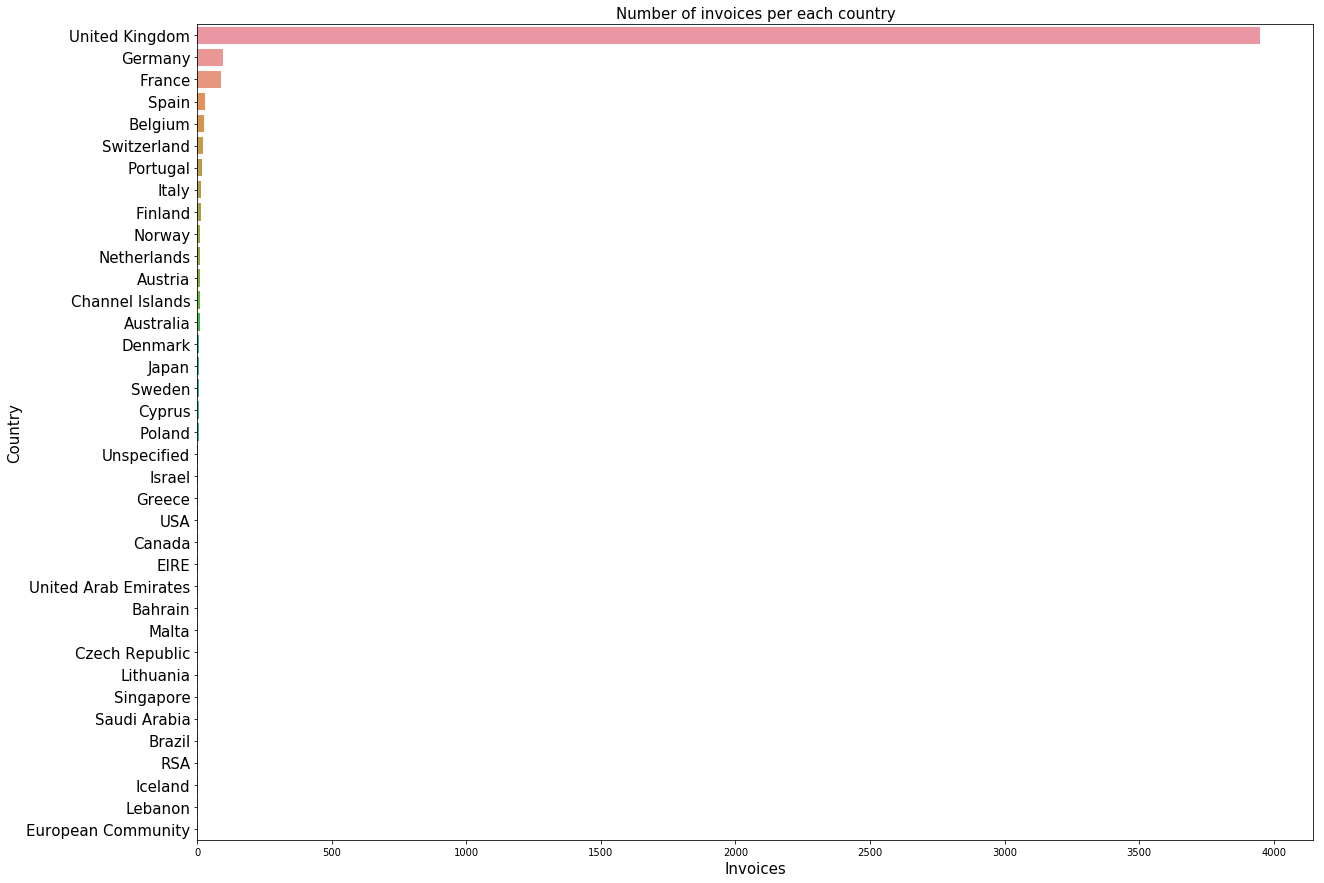

In [19]:
index = df['CustomerID'].drop_duplicates().index
df_unique_customer = df.loc[index, :]
unique_customer_count = df_unique_customer['Country'].value_counts()
#############
plt.figure(figsize=(20,15))
sns.barplot(y=unique_customer_count.index, x=unique_customer_count.values,
            order=unique_customer_count.index)
plt.yticks(size=15)
plt.ylabel('Country', fontsize=15)
plt.xlabel('Invoices', fontsize=15)
plt.title('Number of invoices per each country', fontsize=15)
print('There are {} customers who made {} transactions'.format(len(df['CustomerID'].unique()),
                                                             len(df['InvoiceNo'].unique())))

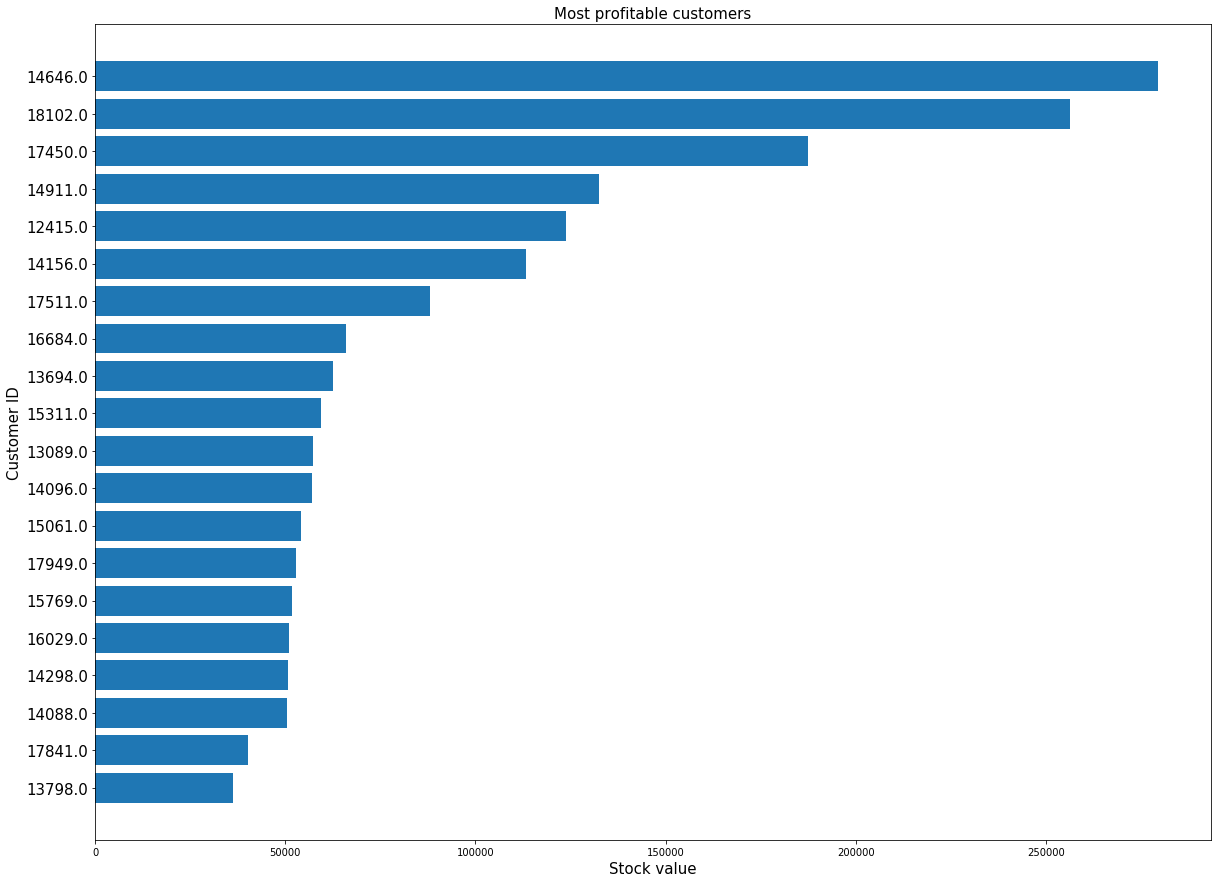

In [20]:
##data
customer_value = df.groupby('CustomerID')['StockValue'].sum().sort_values(ascending=False)
##plot
plt.figure(figsize=(20,15))
plt.barh(y=np.linspace(0,19,20), width=customer_value[:20][::-1].values, align='center', linewidth=10)
plt.yticks(np.linspace(0,19,20), customer_value[:20][::-1].index, size=15)
plt.title('Most profitable customers', fontsize=15)
plt.xlabel('Stock value', fontsize=15)
plt.ylabel('Customer ID', fontsize=15)
plt.show()

In [21]:
customer_20 = customer_value[:20].reset_index()

for i, customer in enumerate(customer_20['CustomerID']):
    value_for_customer = df[df['CustomerID'] == customer]['Country'].unique()[0]
    customer_20.loc[i, 'Country'] = value_for_customer
print('Top 20 most profitable customers are from: ')
customer_20['Country'].value_counts()
                                       

Top 20 most profitable customers are from: 


United Kingdom    16
EIRE               2
Netherlands        1
Australia          1
Name: Country, dtype: int64

Over 90% percent of customers are from United Kingdom. The highest income is generated from client with ID 14646. Stock value of that client is equal to 279 489.02$. Out of 20 top profitable client 16 are from UK, 2 from Ireland and each one from Australia and Netherlands.

# Stock codes and items

In [22]:
stock_code_count = len(df['StockCode'].unique())
print('There are {} different stock codes'.format(stock_code_count))

There are 3684 different stock codes


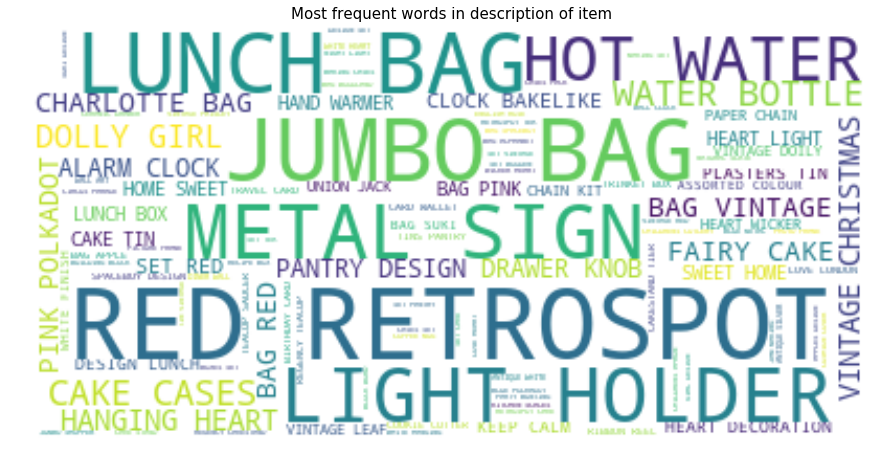

In [23]:
text = " ".join(review for review in df['Description'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in description of item', fontsize=15)
plt.show()

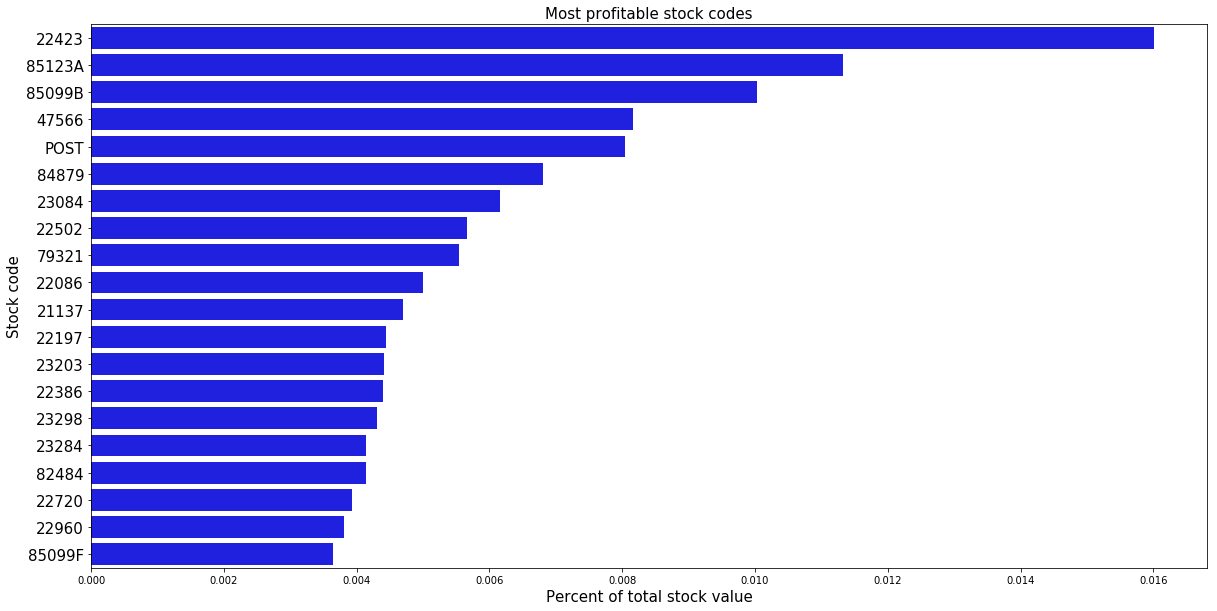

In [24]:
#stock_code_v_counts = df['StockCode'].value_counts(normalize=True)[:20]
stock_code_v_counts = df.groupby('StockCode')['StockValue'].sum().sort_values(ascending=False)[:20]
stock_code_v_counts = stock_code_v_counts/df['StockValue'].sum()
plt.figure(figsize=(20,10))
sns.barplot(y=stock_code_v_counts.index, x=stock_code_v_counts.values,
            order=stock_code_v_counts.index, color='blue')
plt.title('Most profitable stock codes', fontsize=15)
plt.xlabel('Percent of total stock value', fontsize=15)
plt.ylabel('Stock code', fontsize=15)
plt.yticks(size=15)
plt.show()

In [25]:
description_stock_code = stock_code_v_counts.reset_index()
for i, stockcode in enumerate(description_stock_code['StockCode']):
    value_for_stockcode = df[df['StockCode'] == stockcode]['Description'].value_counts().index[0]
    description_stock_code.loc[i, 'Description'] = value_for_stockcode
print('What are these 20 top profitable stock codes?')    
description_stock_code['Description']


What are these 20 top profitable stock codes?


0               REGENCY CAKESTAND 3 TIER
1     WHITE HANGING HEART T-LIGHT HOLDER
2                JUMBO BAG RED RETROSPOT
3                          PARTY BUNTING
4                                POSTAGE
5          ASSORTED COLOUR BIRD ORNAMENT
6                     RABBIT NIGHT LIGHT
7             PICNIC BASKET WICKER SMALL
8                          CHILLI LIGHTS
9        PAPER CHAIN KIT 50'S CHRISTMAS 
10              BLACK RECORD COVER FRAME
11                        POPCORN HOLDER
12              JUMBO BAG VINTAGE DOILY 
13               JUMBO BAG PINK POLKADOT
14                        SPOTTY BUNTING
15         DOORMAT KEEP CALM AND COME IN
16     WOOD BLACK BOARD ANT WHITE FINISH
17     SET OF 3 CAKE TINS PANTRY DESIGN 
18              JAM MAKING SET WITH JARS
19                  JUMBO BAG STRAWBERRY
Name: Description, dtype: object

In [26]:
digit = df['StockCode'].apply(lambda x: 'char' if x.isalpha() else 'number')
char_index = digit[digit == 'char'].index

df_char_stock = df.loc[char_index, :]
print('Unusual stock codes: {}'.format([x for x in df_char_stock['StockCode'].unique()])) 

Unusual stock codes: ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


In [27]:
for stockcode in df_char_stock['StockCode'].unique():
    print('Stock code: {} has {} unique values  - Description {}'.format(stockcode,
                                                                        df[df['StockCode'] == stockcode]['Description'].nunique(),
                                                                       df[df['StockCode'] == stockcode]['Description'].unique()[0]))
    

Stock code: POST has 1 unique values  - Description POSTAGE
Stock code: D has 1 unique values  - Description Discount
Stock code: M has 1 unique values  - Description Manual
Stock code: PADS has 1 unique values  - Description PADS TO MATCH ALL CUSHIONS
Stock code: DOT has 1 unique values  - Description DOTCOM POSTAGE
Stock code: CRUK has 1 unique values  - Description CRUK Commission


Most of the stock codes are just numbers which describe the product but some of them are some kind of text. It seems that there is **POST** service available. Code **D** is assigned to discounted transactions which occurs only in FK invoices. **PADS** are some kind of gifts. **DOTCOM** is as well post service I suppose. **CRUK** is a charged fee to the customer with ID 14096. Not sure about **M**.

For the purpose of further analysis I will only include the sales invoices to avoid observations with negative quantity and huge value of transactions whic are counted as outliers.

In [28]:
df_low = df[df['InvoiceType'] == 'FV']
outlier_drop = df_low['StockValue'].quantile(0.95)
df_low = df_low[df_low['StockValue'] < outlier_drop]
print(df_low.shape[0]/df.shape[0])

0.9281614634158332


In [29]:
df_low['CustomerID'].nunique()/df['CustomerID'].nunique()

0.9661482159194876

After dropping 5% of data we lost a little more than 7% of observations and less than 3,5% of customers.

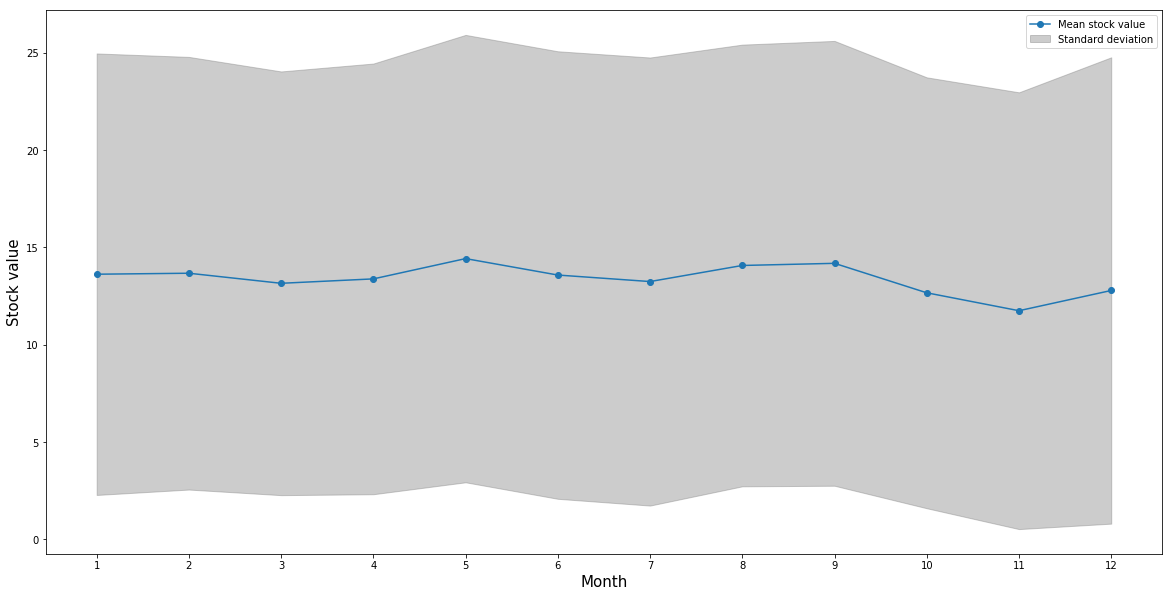

In [30]:
stock_value_group_mean = df_low['StockValue'].groupby(df_low['Month']).mean()
stock_value_group_std = df_low['StockValue'].groupby(df_low['Month']).std()
plt.figure(figsize=(20,10))
plt.plot(stock_value_group_mean, marker="o", label='Mean stock value')
plt.fill_between(stock_value_group_mean.index, stock_value_group_mean.values - stock_value_group_std.values, stock_value_group_mean.values + stock_value_group_std.values,
                 color='gray', alpha=0.4, label='Standard deviation')
plt.xticks(np.linspace(1,12,12))
plt.xlabel('Month', fontsize=15)
plt.ylabel('Stock value', fontsize=15)
plt.legend()
plt.show()

In [31]:
df_low['StockValue'].std()/df_low['StockValue'].mean()

0.8628093965660468

The mean stock value over the year is constant. The variation coefficient is 0,86. Just to reminder in the not filtered data it was about 20~. In that case filtering data seems needed

****RFM segmentation****

Next step is to cluster clients by RFM analysis (Recency, Frequency, Monetary). It groups customers based on their transaction history – how recently, how often and how much did they buy.

In [32]:
date = df_low['InvoiceDate'].max() + timedelta(days=1)

In [33]:
rfm = df_low.groupby(['CustomerID']).agg({'StockValue': lambda x: x.sum(),
                                'CustomerID': 'count',
                               'InvoiceDate': lambda x: (date-x.max()).days})
rfm.rename(columns={'StockValue': 'TotalMonetary',
                    'CustomerID': 'TotalTransactions',
                    'InvoiceDate': 'LastPurchase'}, inplace=True)
rfm.dropna(inplace=True)


print(rfm.shape[0])
rfm.head(5)

4224


,TotalMonetary,TotalTransactions,LastPurchase
CustomerID,,,
12347.0,3516.98,175,2.0
12348.0,803.24,23,75.0
12349.0,1457.55,72,19.0
12350.0,334.40,17,310.0
12352.0,1505.74,80,36.0


We still have 4224 unique customers to cluster. Table above shows 3 attribute that every customer will be clustered on.

TotalMonetary = total amount of cash that customer has spend

TotalTransactions = number of transactions for each customer

LastPurchase = number of days when was the last transaction

Right now every attribute get a score from 1 to 5 (the scale is dependent on the author) where 1 is best and 5 the worst. I'm about to get this score by dividing values into quantilies for each attribute. 

In [34]:
quantile = rfm.quantile(np.linspace(0,1,5))
quantile

,TotalMonetary,TotalTransactions,LastPurchase
0.00,0.0000,1.0,1.0
0.25,246.1975,17.0,18.0
0.50,552.3450,41.0,51.0
0.75,1337.5400,98.0,142.0
1.00,105160.1000,7817.0,374.0


In [35]:
def get_bins_monetary(x):
    if x <= quantile.loc[0, 'TotalMonetary']:
        return 5
    elif x <= quantile.loc[0.25, 'TotalMonetary']:
        return 4
    elif x <= quantile.loc[0.5, 'TotalMonetary']:
        return 3
    elif x <= quantile.loc[0.75, 'TotalMonetary']:
        return 2
    else:
        return 1
    
def get_bins_transactions(x):
    if x <= quantile.loc[0, 'TotalTransactions']:
        return 5
    elif x <= quantile.loc[0.25, 'TotalTransactions']:
        return 4
    elif x <= quantile.loc[0.5, 'TotalTransactions']:
        return 3
    elif x <= quantile.loc[0.75, 'TotalTransactions']:
        return 2
    else:
        return 1
    
def get_bins_purchase(x):
    if x <= quantile.loc[0, 'LastPurchase']:
        return 1
    elif x <= quantile.loc[0.25, 'LastPurchase']:
        return 2
    elif x <= quantile.loc[0.5, 'LastPurchase']:
        return 3
    elif x <= quantile.loc[0.75, 'LastPurchase']:
        return 4
    else:
        return 5

In [36]:
rfm['m_rate'] = rfm['TotalMonetary'].apply(get_bins_monetary)
rfm['f_rate'] = rfm['TotalTransactions'].apply(get_bins_transactions)
rfm['r_rate'] = rfm['LastPurchase'].apply(get_bins_purchase)
rfm['RFM'] = rfm['m_rate'].map(str) + rfm['f_rate'].map(str) + rfm['r_rate'].map(str)
rfm['RFM_value'] = rfm['m_rate'] + rfm['f_rate'] + rfm['r_rate']
rfm.head(10)

,TotalMonetary,TotalTransactions,LastPurchase,m_rate,f_rate,r_rate,RFM,RFM_value
CustomerID,,,,,,,,
12347.0,3516.98,175,2.0,1,1,2,112,4
12348.0,803.24,23,75.0,2,3,4,234,9
12349.0,1457.55,72,19.0,1,2,3,123,6
12350.0,334.40,17,310.0,3,4,5,345,12
12352.0,1505.74,80,36.0,1,2,3,123,6
12353.0,89.00,4,204.0,4,4,5,445,13
12354.0,1079.40,58,232.0,2,2,5,225,9
12355.0,264.40,11,214.0,3,4,5,345,12
12356.0,1439.83,47,23.0,1,2,3,123,6


That's how the table looks like after signing every score

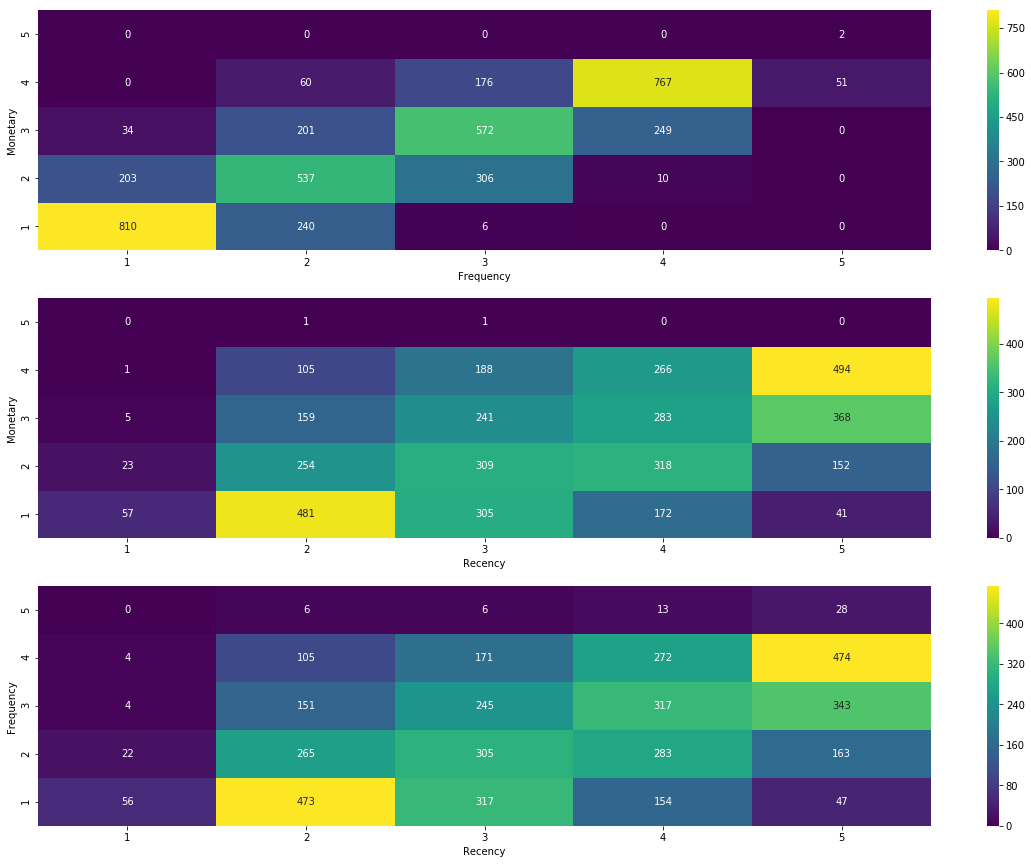

In [37]:
cross_table1 = pd.crosstab(index=rfm['m_rate'], columns=rfm['f_rate'])
cross_table2 = pd.crosstab(index=rfm['m_rate'], columns=rfm['r_rate'])
cross_table3 = pd.crosstab(index=rfm['f_rate'], columns=rfm['r_rate'])
plt.figure(figsize=(20,15))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
plt.show()

In [38]:
print('Correlation monetary - frequency: ', rfm[['m_rate', 'f_rate']].corr().iloc[1,0])
print('Correlation monetary - recency: ', rfm[['m_rate', 'r_rate']].corr().iloc[1,0])
print('Correlation frequency - recency: ', rfm[['f_rate', 'r_rate']].corr().iloc[1,0])

Correlation monetary - frequency:  0.8277537361261051
Correlation monetary - recency:  0.4548989756454796
Correlation frequency - recency:  0.4543825023379956
